# McDonald's Reviews
In this notebook we train a naive Bayes classifier to predict the number of stars of a review.


In [54]:
import pandas as pd
import nltk
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np

## Load and explore data

In [15]:
df = pd.read_csv("csv/mcdonalds_reviews.csv", encoding="latin-1")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18149 entries, 0 to 18148
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   business_id  18149 non-null  object 
 1   stars        18149 non-null  float64
 2   text         18149 non-null  object 
dtypes: float64(1), object(2)
memory usage: 425.5+ KB
None


In [16]:
#check for faulty stars values 
unique_stars = df["stars"].unique()
print(unique_stars)

[2. 1. 4. 5. 3.]


In [17]:
#cast stars to int
print(df.dtypes)

business_id     object
stars          float64
text            object
dtype: object


In [18]:
df["stars"] = df["stars"].astype(int)

In [19]:
# check for empty values
print(df.isnull().sum())

business_id    0
stars          0
text           0
dtype: int64


In [20]:
# check for empty strings in the text
print(df[df["text"] == ""])

Empty DataFrame
Columns: [business_id, stars, text]
Index: []


In [21]:
# check for reviews that are only whitespaces
print(df[df["text"].str.isspace()])

Empty DataFrame
Columns: [business_id, stars, text]
Index: []


In [39]:
# look at distribution of stars
print(df["stars"].value_counts())

1    12277
2     1849
5     1591
3     1294
4     1138
Name: stars, dtype: int64


## Preprocessing

In [25]:
# make lowercase
df["text"] = df["text"].str.lower()

In [26]:
# remove anything but letters
df["text"] = df["text"].str.replace('[^a-z]', ' ')

C:\Users\flyin\AppData\Local\Temp\ipykernel_6684\23516537.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["text"] = df["text"].str.replace('[^a-z]', ' ')


In [27]:
# remove stopwords
spacy.cli.download('en_core_web_sm')
spacy.load('en_core_web_sm')
stopwords = spacy.lang.en.stop_words.STOP_WORDS
df["text"]  = df["text"] .apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [28]:
# lemmatize
nltk.download('wordnet')
nltk.download('omw-1.4')
wnl = nltk.WordNetLemmatizer()
df["text"] = df["text"].apply(lambda x: ' '.join([wnl.lemmatize(word) for word in x.split()]))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\flyin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\flyin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [29]:
# look at some examples
print(df["text"].head(10))

0    mcdonalds closest home forever drive distance ...
1    know shouldnt expect asked drive menu availabl...
2    ive eaten gotten food drivethru time food fine...
3    mood quick bite mcdonaldsi thought place went ...
4     amber tried old fry werent having cold burnt one
5        giving star shamrock shake delicious bad year
6    good customer service great manager louder mic...
7    agree previous review satisfactory drivethroug...
8    mcdonalds need know serve purpose id complain ...
9    mcdonalds terrible place dirty employee long o...
Name: text, dtype: object


In [30]:
# collapse whitespaces and remove leading and trailing whitespaces
df["text"] = df["text"].str.replace(' +', ' ')
df["text"] = df["text"].str.strip()

print(df["text"].head(10))

C:\Users\flyin\AppData\Local\Temp\ipykernel_6684\1213405689.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["text"] = df["text"].str.replace(' +', ' ')


0    mcdonalds closest home forever drive distance ...
1    know shouldnt expect asked drive menu availabl...
2    ive eaten gotten food drivethru time food fine...
3    mood quick bite mcdonaldsi thought place went ...
4     amber tried old fry werent having cold burnt one
5        giving star shamrock shake delicious bad year
6    good customer service great manager louder mic...
7    agree previous review satisfactory drivethroug...
8    mcdonalds need know serve purpose id complain ...
9    mcdonalds terrible place dirty employee long o...
Name: text, dtype: object


## Vectorization

In [32]:
# we first use CountVectorizer to create a bag of words
vectorizer = CountVectorizer()
reviews_bag_of_words = vectorizer.fit_transform(df["text"])

## Train-Test split

In [33]:
# split into training and test set
X_train, X_test, y_train, y_test = train_test_split(reviews_bag_of_words, df["stars"], test_size=0.2, random_state=1)

## Train Model and predict

In [34]:
# train a Multinomial Naive Bayes classifier
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [35]:
# predict the test set
y_pred = clf.predict(X_test)

## Evaluate model

In [36]:
# calculate the accuracy
from sklearn.metrics import accuracy_score
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  0.7121212121212122


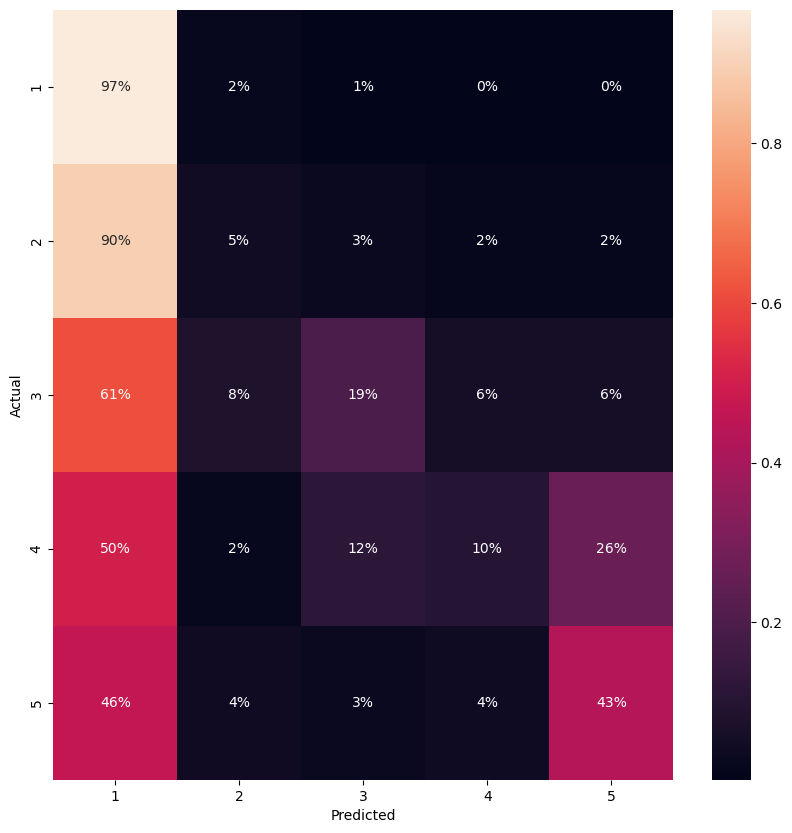

In [41]:
# we create the confusion matrix with percent values
cm = confusion_matrix(y_test, y_pred, normalize='true')

# we plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.0%', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5], ax=ax)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The accuracy is of our model appears quite good at first, but when we look at the confusion matrix, we can see that it is only good at predicting 1 star reviews. This might be due to our data being very imbalanced:

In [42]:
print(y_train.value_counts())

1    9839
2    1477
5    1277
3    1035
4     891
Name: stars, dtype: int64


In [56]:
# lets look at the balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print('Balanced accuracy: ', balanced_accuracy_score(y_test, y_pred))

Balanced accuracy:  0.34668956118013944


## 2. attempt with balanced data

Now we try to improve the model by balancing the dataset to removing the bias towards 1-star reviews. We do this by downsampling the majority class.

In [43]:
# we remove reviews for each star until there are only 891 reviews left for each star (this is the lowest number of reviews for a star)
df_balanced = df.groupby('stars').apply(lambda x: x.sample(n=891, random_state=1)).reset_index(drop = True)

In [44]:
print(df_balanced["stars"].value_counts())

1    891
2    891
3    891
4    891
5    891
Name: stars, dtype: int64


In [46]:
# create a bag of words
vectorizer = CountVectorizer()
balanced_reviews_bag_of_words = vectorizer.fit_transform(df_balanced["text"])

In [47]:
# split
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(balanced_reviews_bag_of_words, df_balanced["stars"], test_size=0.2, random_state=1)

In [48]:
# train
clf_balanced = MultinomialNB()
clf_balanced.fit(X_train_balanced, y_train_balanced)

MultinomialNB()

In [49]:
# predict the test set
y_pred_balanced = clf_balanced.predict(X_test_balanced)

## Evaluate 2. Model attempt

In [50]:
# calculate the accuracy
from sklearn.metrics import accuracy_score
print('Accuracy: ', accuracy_score(y_test_balanced, y_pred_balanced))

Accuracy:  0.4657687991021324


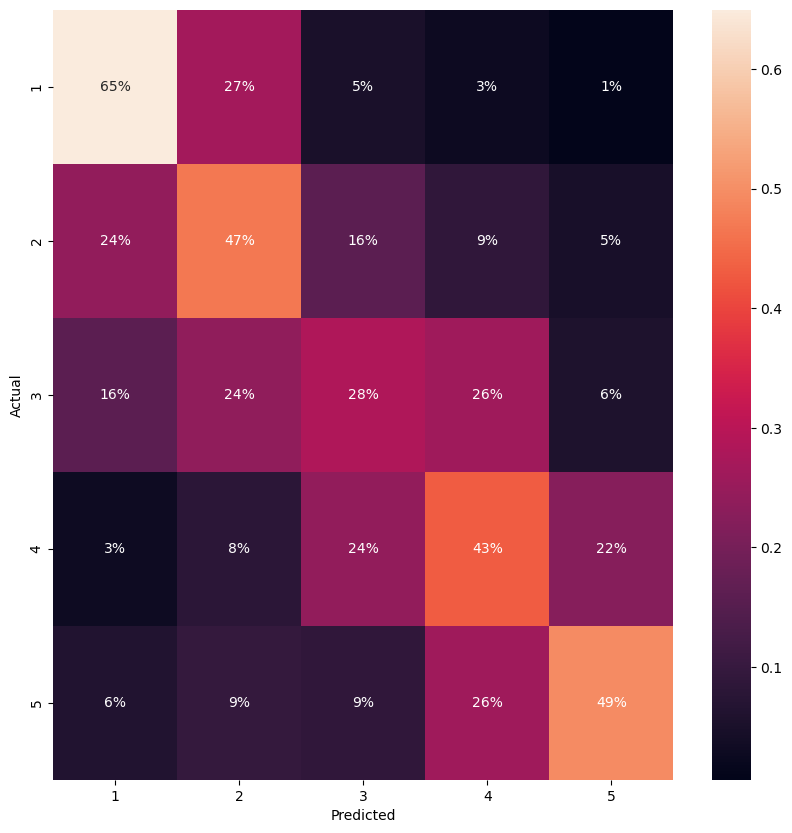

In [51]:
# confusion matrix
cm = confusion_matrix(y_test_balanced, y_pred_balanced, normalize='true')
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.0%', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5], ax=ax)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The accuracy is quite a lot lower now, but overall, this is a more useful model.

In the confusion matrix we can see that the model is better at predicting extreme reviews (1 and 5 star) than reviews in the middle. This makes sense because 2, 3 and 4 star reviews are more likely to use similar language, while 1 and 5 star reviews might use more extreme language.

In [57]:
# lets look at the balanced accuracy

print('Balanced accuracy: ', balanced_accuracy_score(y_test_balanced, y_pred_balanced))

Balanced accuracy:  0.46500155515264796


As we can see, for the second model, the balanced accuracy is exactly the same as the accuracy. This is because the dataset was is balanced. The balanced accuracy is now significantly higher than for the first model.

In [55]:
# Look at the accuracy with a tolerance of 1 star
def custom_accuracy(y_true, y_pred):
    # Clip the predictions to be within the range [1, 5]
    y_pred = np.clip(y_pred, 1, 5)
    
    # Calculate the absolute difference between true and predicted values
    absolute_diff = np.abs(y_true - y_pred)
    
    # Check if the absolute difference is within the tolerance of ±1
    within_tolerance = np.less_equal(absolute_diff, 1)
    
    # Calculate the percentage of predictions within the tolerance
    accuracy = np.mean(within_tolerance)
    
    return accuracy

print(custom_accuracy(y_test_balanced, y_pred_balanced))

0.8406285072951739


We can see that the accuracy is a lot higher when we allow the model to be off by 1 star.